In [1]:
import os
import random
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gdown

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

from aegear.model import EfficientUNet
from aegear.datasets import DetectionDataset, RandomPoissonNoise
from aegear.utils import get_latest_model_path

In [2]:
def get_confidence(heatmap):
    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w
    return heatmap[0, 0, y, x].item()

def overlay_heatmap_on_rgb(rgb_tensor, heatmap, alpha=0.5, centroid_color=(0, 1, 0)):
    """
    Overlay heatmap onto RGB image and draw a circle at the predicted centroid.
    
    Args:
        rgb_tensor: [3, H, W] tensor
        heatmap: [H, W] numpy array
        alpha: blending weight
        centroid_color: (R, G, B) tuple in range 0–1
    Returns:
        overlay: [H, W, 3] numpy image
    """
    rgb = rgb_tensor.permute(1, 2, 0).cpu().numpy()
    rgb = rgb * 0.229 + 0.485
    rgb = rgb.clip(0, 1)

    heatmap_color = plt.cm.hot(heatmap)[..., :3]
    overlay = (1 - alpha) * rgb + alpha * heatmap_color

    # Find centroid
    flat_idx = heatmap.reshape(-1).argmax()
    h, w = heatmap.shape
    cy = flat_idx // w
    cx = flat_idx % w

    # Draw circle
    overlay_uint8 = (overlay * 255).astype(np.uint8)
    cx_int, cy_int = int(cx), int(cy)
    color_bgr = tuple(int(c * 255) for c in reversed(centroid_color))
    cv2.circle(overlay_uint8, (cx_int, cy_int), 4, color_bgr, thickness=1)

    return overlay_uint8 / 255.0

def save_epoch_visualization(val_results, stage, epoch, output_dir="vis_epochs", N=5):
    os.makedirs(output_dir, exist_ok=True)

    # Sort by distance
    sorted_results = sorted(val_results, key=lambda r: r['confidence'], reverse=True)
    worst = sorted_results[-N:]
    best = sorted_results[:N]
    middle = sorted_results[len(sorted_results)//2 - N//2 : len(sorted_results)//2 + N//2]

    samples = worst[::-1] + middle + best  # worst at top, best at bottom
    total_rows = len(samples)

    _, axes = plt.subplots(total_rows, 3, figsize=(9, 3 * total_rows))

    for i, result in enumerate(samples):
        search = result['search']
        gt = result['gt_heatmap']
        pred = result['pred_heatmap']
        xg, yg = result['gt_centroid']
        xp, yp = result['pred_centroid']
        confidence = result['confidence']

        search_img = TF.to_pil_image(denormalize(search))
        search_np = TF.to_tensor(search_img).permute(1, 2, 0).numpy()

        # Normalize heatmaps
        pred_norm = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
        gt_norm = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)
        diff_norm = np.abs(pred_norm - gt_norm)

        # Overlay prediction heatmap
        overlay = 0.6 * search_np + 0.4 * plt.cm.jet(pred_norm)[..., :3]
        overlay = np.clip(overlay, 0, 1)

        # Diff colormap
        diff_rgb = plt.cm.magma(diff_norm)[..., :3]

        # Plot
        axes[i, 0].imshow(overlay)
        axes[i, 0].scatter([xp], [yp], c='red', marker='x', label='Pred')
        axes[i, 0].scatter([xg], [yg], c='green', marker='o', label='GT')
        axes[i, 0].set_title(f"Search | Conf: {confidence:.2f}")
        axes[i, 0].legend()

        axes[i, 1].imshow(diff_rgb)
        axes[i, 1].set_title("Abs Diff")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"stage_{stage:03d}_epoch_{epoch:03d}.png")
    plt.savefig(out_path)
    plt.close()


def save_epoch_activation_visualization(val_results, model, device, stage_n, epoch, output_dir="vis_activations", N=5, channels_per_stage=3):
    def get_activations(model):
        activations = {}

        def get_activation(name):
            def hook(model, input, output):
                activations[name] = output.detach().cpu()
            return hook

        model.enc1.register_forward_hook(get_activation('enc1'))
        model.enc2.register_forward_hook(get_activation('enc2'))
        model.enc3.register_forward_hook(get_activation('enc3'))
        model.enc4.register_forward_hook(get_activation('enc4'))

        model.up3.register_forward_hook(get_activation('dec3'))
        model.up2.register_forward_hook(get_activation('dec2'))
        model.up1.register_forward_hook(get_activation('dec1'))
        model.up0.register_forward_hook(get_activation('dec0'))

        model.out.register_forward_hook(get_activation('out'))

        return activations

    def denormalize(img_tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
        return (img_tensor * std + mean).clamp(0, 1)

    os.makedirs(output_dir, exist_ok=True)

    activations = get_activations(model)

    # Sort by confidence
    sorted_results = sorted(val_results, key=lambda r: r['confidence'], reverse=True)
    worst = sorted_results[-N:]
    best = sorted_results[:N]
    middle = sorted_results[len(sorted_results)//2 - N//2 : len(sorted_results)//2 + N//2]

    samples = worst[::-1] + middle + best
    total_rows = len(samples)

    stages = ['enc1', 'enc2', 'enc3', 'enc4', 'dec3', 'dec2', 'dec1', 'dec0', 'out']
    n_cols = 1 + channels_per_stage * len(stages)

    fig, axs = plt.subplots(total_rows, n_cols, figsize=(n_cols * 2.5, total_rows * 3))
    if total_rows == 1:
        axs = axs[None, :]  # force 2D

    model.eval()

    for row, sample in enumerate(samples):
        search = sample['search'].unsqueeze(0).to(device)
        xg, yg = sample['gt_centroid']
        xp, yp = sample['pred_centroid']
        confidence = sample['confidence']

        with torch.no_grad():
            _ = model(search)

        # Image and heatmap overlay
        img_np = denormalize(search[0]).permute(1, 2, 0).cpu().numpy()
        hm_np = sample['pred_heatmap'].numpy()

        overlay = img_np.copy()
        overlay[..., 0] = np.clip(overlay[..., 0] + 0.5 * hm_np, 0, 1)

        axs[row, 0].imshow(overlay)
        axs[row, 0].scatter([xg], [yg], c='green', marker='o', label='GT')
        axs[row, 0].scatter([xp], [yp], c='red', marker='x', label='Pred')
        axs[row, 0].set_title(f'Conf: {confidence:.2f}')
        axs[row, 0].axis('off')
        axs[row, 0].legend()

        # Activations per stage
        col = 1
        for stage in stages:
            act = activations[stage][0]  # single-sample activations

            for ch in range(channels_per_stage):
                if ch < act.shape[0]:
                    axs[row, col].imshow(act[ch].detach().cpu().numpy(), cmap='viridis')
                    axs[row, col].set_title(f'{stage} | Ch {ch}')
                else:
                    axs[row, col].axis('off')
                axs[row, col].axis('off')
                col += 1

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"activation_stage_{stage_n:03d}_epoch_{epoch:03d}.png")
    plt.savefig(out_path, dpi=200)
    plt.close()

def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return t * std + mean

In [3]:
# 1. Device selection
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


In [4]:
dataset_dir = '../data/training'
video_dir = "../data/video"

annotations = {
    #"E7": {
        #"file": 'tracking_E7_clean.json',
        #"annotation_gdrive_id": "1b8UgWED20Gtkn0ovqizONTlFH-oNYJ_a",
        #"video_gdrive_id": "1FJypI1WmZJj4iEo9nVfBvP8FjaoDf1Ob"
    #},
    "K9": {
        "file": 'tracking_K9_clean2.json',
        "annotation_gdrive_id": "12jLIHBySVG3G0Ie52NlmRHQ7U3Sv6ca-",
        "video_gdrive_id": "1iZMfmCJnYsIxBIXqVwRrpubO2-_uItHU"
    },
    "S1": {
        "file": 'tracking_S1_clean.json',
        "annotation_gdrive_id": "1VKNPRTnNb0n5oUBG9hx3ZkLns9CMcs7R",
        "video_gdrive_id": "1aGFLRtPjjiUZjY8k5xH-EKF3sHQSfNnE"
    }
}

# Create directories if they do not exist.
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

bar = tqdm(annotations.items(), desc="Downloading dataset and videos")
for key, annotation_settings in bar:
    bar.set_postfix_str(key)

    annotations_file = os.path.join(dataset_dir, annotation_settings["file"])
    video_file = os.path.join(video_dir, f"{key}.MOV")
    annotation_file_id = annotation_settings["annotation_gdrive_id"]
    video_file_id = annotation_settings["video_gdrive_id"]

    # Check if each of the dataset units is present
    if not os.path.exists(annotations_file):
        print("Downloading dataset...")
        url = f'https://drive.google.com/uc?id={annotation_file_id}'
        gdown.download(url, annotations_file, quiet=False)

    if not os.path.exists(video_file):
        print("Downloading video...")
        url = f'https://drive.google.com/uc?id={video_file_id}'

        gdown.download(url, video_file, quiet=False)

In [5]:
interpolation_smoothness = 5.0

dataset_annotations = [os.path.join(dataset_dir, annotation_settings["file"]) for annotation_settings in annotations.values()]

augmentation_transforms = transforms.Compose([
    RandomPoissonNoise(p=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.05, 0.75)),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.15),
])

train_fraction = 0.9
train_dataset, val_dataset = DetectionDataset.build_split_datasets(
    dataset_annotations,
    video_dir,
    output_size=128,
    crop_size=256,
    train_fraction=train_fraction,
    temporal_jitter_range=5,
    center_offset_range=30,
    negative_sample_prob=0.05,
    gaussian_sigma=15.0,
    interpolation_smoothness=interpolation_smoothness,
    augmentation_transforms=augmentation_transforms,
    rotation_range=30.0,
    scale_range=0.3)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 2564
Validation dataset size: 286


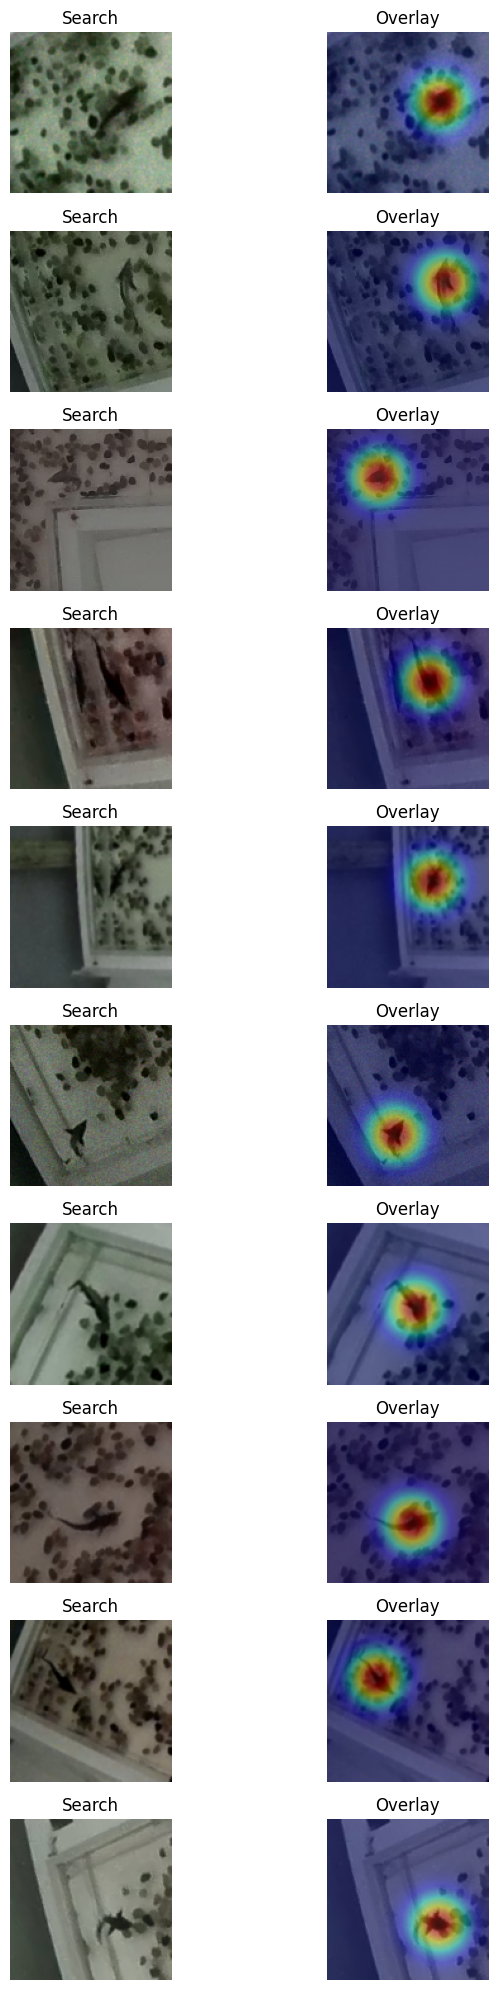

In [6]:
N = 10  # Number of samples to visualize

fig, axes = plt.subplots(N, 2, figsize=(8, 2 * N))

for i in range(N):
    random.seed(i)
    idx = random.randint(0, len(train_dataset) - 1)
    template, heatmap = train_dataset[idx]

    template_img = TF.to_pil_image(denormalize(template))
    heatmap_np = heatmap.squeeze().numpy()

    # === Normalize heatmap for display
    heatmap_norm = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

    # === Blend
    search_np = TF.to_tensor(template_img).permute(1, 2, 0).numpy()
    heatmap_rgb = plt.cm.jet(heatmap_norm)[..., :3]
    overlay = 0.6 * search_np + 0.4 * heatmap_rgb
    overlay = np.clip(overlay, 0, 1)

    # === Plot
    axes[i, 0].imshow(template_img)
    axes[i, 0].set_title("Search")

    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title("Overlay")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
model_dir = '../data/models/efficient_unet'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'
epoch_vis = f'{model_dir}/epoch_vis'

# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(epoch_vis, exist_ok=True)

In [ ]:
# Model settings for training
continue_training = True # Continue training from the latest production model
use_best_model = True # If contnue_training is True, uses the cached best_model.pth, else uses the latest production model.

model = EfficientUNet(weights="IMAGENET1K_V1")

if continue_training:
   if use_best_model:
      # Load the best model
      best_model_path = os.path.join(model_dir, "best_model.pth")
      assert os.path.exists(best_model_path)

   else:     
      unet_model_filename = "model_efficient_unet"
      best_model_path = get_latest_model_path(model_dir, "..", unet_model_filename)

   print("Continuing training of the Siamese model from:", best_model_path)
   model.load_state_dict(torch.load(best_model_path, map_location=device), strict=False)

else:
   print("Training a new UNet model from ImageNet weights.")

model.to(device)

# Freeze early layers
training_stages = [
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
       ],
       "epochs": 5,
       "lr": 1e-4,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
            model.up3,
            model.up2,
       ],
       "epochs": 5,
       "lr": 5e-3,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
            model.up3,
       ],
       "epochs": 5,
       "lr": 2.5e-4,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
       ],
       "epochs": 5,
       "lr": 1.5e-4,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
       ],
       "epochs": 5,
       "lr": 5.0e-5,
   },
]






Training a new UNet model from ImageNet weights.


In [9]:
def weighted_bce_with_logits(pred, target, limit=0.5, pos_weight=20.0):
    weights = torch.ones_like(target)
    weights[target > limit] = pos_weight  # emphasize center of Gaussian

    bce = F.binary_cross_entropy_with_logits(pred, target, weight=weights, reduction='mean')
    return bce

def get_centroids_per_sample(heatmap):
    b, _, _, w = heatmap.shape
    heatmaps = heatmap.squeeze(1)  # shape: [B, H, W]
    centroids = []

    for i in range(b):
        hm = heatmaps[i]
        hm_sum = hm.mean().item()

        if hm_sum < 1e-8:
            centroids.append(None)
        else:
            flat_idx = torch.argmax(hm)
            y = flat_idx // w
            x = flat_idx % w
            conf = hm[y, x]
            centroids.append((x.float(), y.float(), conf.float()))

    return centroids

def centroid_distance_loss(pred, target):
    preds = get_centroids_per_sample(torch.sigmoid(pred))
    targets = get_centroids_per_sample(target)

    distances = []

    for p, t in zip(preds, targets):
        if p is not None and t is not None:
            x_p, y_p, _ = p
            x_t, y_t, _ = t
            dist = torch.sqrt((x_p - x_t) ** 2 + (y_p - y_t) ** 2 + 1e-8)
            distances.append(dist)

    if not distances:
        return torch.tensor(0.0).to(pred.device), 0

    return torch.stack(distances).mean(), len(distances)

In [ ]:
# Training loop
best_val_loss = float('inf')
losses = []

epoch_save_interval = 1
centroid_weight = 0.25  # weight for centroid distance loss
sparsity_weight = 0.01  # weight for sparsity loss

for stage, training_stage in enumerate(training_stages):

    freeze_layers = training_stage["freeze_layers"]
    epochs = training_stage["epochs"]

    for param in model.parameters():
        param.requires_grad = True

    for layer in freeze_layers:
        for param in layer.parameters():
            param.requires_grad = False

    optimizer = torch.optim.Adam(model.parameters(), lr=training_stage["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5,
        patience=3,
    )

    for epoch in range(epochs):
        model.train()

        # Keep encoder in eval mode to avoid BN stat updates
        for layer in freeze_layers:
            layer.eval()

        train_loss = 0.0

        random.seed(time.time())
        train_bar = tqdm(train_loader, desc=f"Training stage {stage + 1}, epoch: {epoch + 1}", leave=False)
        for search, heatmap in train_bar:
            search = search.to(device)
            target = heatmap.to(device)

            output = model(search)

            mse = weighted_bce_with_logits(output, target)
            cdist, distances = centroid_distance_loss(output, target)
            sparsity_loss = output.pow(2).mean()

            loss = (
                mse
                + centroid_weight * cdist
                + sparsity_weight * sparsity_loss
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        model.eval()
        val_loss = 0.0
        val_results = []  # NEW

        with torch.no_grad():
            random.seed(42)
            val_bar = tqdm(val_loader, desc=f"Validation stage {stage + 1}, epoch: {epoch + 1}", leave=False)

            for search, heatmap in val_bar:
                search = search.to(device)
                target = heatmap.to(device)

                output = model(search)

                mse = weighted_bce_with_logits(output, target)
                cdist, distances = centroid_distance_loss(output, target)
                sparsity_loss = output.pow(2).mean()

                loss = (
                    mse
                    + centroid_weight * cdist
                    + sparsity_weight * sparsity_loss
                )

                val_loss += loss.item()
                val_bar.set_postfix(loss=loss.item())

                # --------- COLLECT SAMPLE DATA ---------
                # Resize output and heatmap
                pred_resized = F.interpolate(torch.sigmoid(output), size=template.shape[-2:], mode='bilinear', align_corners=False)
                target_resized = F.interpolate(target, size=template.shape[-2:], mode='bilinear', align_corners=False)

                # Get centroids and confidence per sample
                centroids_pred = get_centroids_per_sample(pred_resized)
                centroids_gt = get_centroids_per_sample(target_resized)

                for i in range(search.size(0)):
                    p = centroids_pred[i]
                    t = centroids_gt[i]

                    if p is None or t is None:
                        continue  # skip bad samples

                    x_pred, y_pred, confidence = p
                    x_gt, y_gt, _ = t

                    xp, yp = x_pred.item(), y_pred.item()
                    xg, yg = x_gt.item(), y_gt.item()

                    dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)

                    val_results.append({
                        'search': search[i].cpu(),
                        'gt_heatmap': target_resized[i, 0].cpu(),
                        'pred_heatmap': pred_resized[i, 0].cpu(),
                        'gt_centroid': (xg, yg),
                        'pred_centroid': (xp, yp),
                        'confidence': confidence.item(),
                        'distance': dist,
                    })

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        losses.append((train_loss, val_loss))

        scheduler.step(val_loss)

        save_epoch_visualization(val_results, stage, epoch, output_dir=epoch_vis, N=10)
        save_epoch_activation_visualization(val_results, model, device, stage, epoch, output_dir=epoch_vis, N=5)

        print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("New best model, saving.")
            torch.save(model.state_dict(), f'{model_dir}/best_model_stage_{stage+1}.pth')

        if (epoch + 1) % epoch_save_interval == 0:
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_stage_{stage+1}_epoch_{epoch+1}.pth'))

Training stage 1, epoch: 1:   0%|          | 0/641 [00:00<?, ?it/s]

Validation stage 1, epoch: 1:   0%|          | 0/72 [00:00<?, ?it/s]

C:\Users\relja\AppData\Local\Temp\ipykernel_132800\655151392.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff_norm = np.abs(pred_norm - gt_norm)


Epoch 1/5 - Train: 4.9668 | Val: 2.5797
New best model, saving.


Training stage 1, epoch: 2:   0%|          | 0/641 [00:00<?, ?it/s]

Validation stage 1, epoch: 2:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 2/5 - Train: 2.6204 | Val: 2.2982
New best model, saving.


Training stage 1, epoch: 3:   0%|          | 0/641 [00:00<?, ?it/s]

Validation stage 1, epoch: 3:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 3/5 - Train: 2.2934 | Val: 2.1426
New best model, saving.


Training stage 1, epoch: 4:   0%|          | 0/641 [00:00<?, ?it/s]

In [ ]:
# Plotting the losses
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))
model.eval()
model.to(device);

In [ ]:
results = []
total_distances = []
total_confidences = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for imgs, heatmaps in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = torch.sigmoid(model(imgs))

        centroids_pred = get_centroids_per_sample(preds)
        centroids_gt = get_centroids_per_sample(heatmaps)

        for i in range(len(imgs)):
            p = centroids_pred[i]
            t = centroids_gt[i]

            if p is None or t is None:
                continue

            x_pred, y_pred, confidence = p
            x_gt, y_gt, _ = t

            xp, yp = x_pred.item(), y_pred.item()
            xg, yg = x_gt.item(), y_gt.item()
            confidence = confidence.item()

            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)
            total_distances.append(dist)
            total_confidences.append(confidence)

            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

            img = imgs[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'confidence': confidence,
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
avg_conf = np.mean(total_confidences)
print(f"\nAverage centroid distance: {avg_dist:.2f} px, Average confidence: {avg_conf:.2f}")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")


In [ ]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']
    conf = result['confidence']

    gt_value_center = gt.numpy()[int(yg), int(xg)]
    p_value_center = pred.numpy()[int(yp), int(xp)]

    print(f"GT Value at center: {gt_value_center:.2f}, Pred Value at center: {p_value_center:.2f}")

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT')
    axs[0].scatter([xp], [yp], c='red', label='Pred')
    axs[0].set_title(f'Image (Err: {dist:.1f}px, Conf: {conf:.2f})')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()

In [ ]:
# Show some of the worst predictions
#
# The worst ones are expected to be the outliers in the
# dataset, as we know we have some bad labeling.
for i in range(10):
    show_sample(results[i], index=i+1)

In [ ]:
result_size = len(results)
# Show the middle ones
for i in range(result_size//2-5, result_size//2+5):
    show_sample(results[i], index=i+1)

In [ ]:
# Show some of the best predictions
for i in range(result_size-10, result_size):
    show_sample(results[i], index=i+1)

In [ ]:
# Visualize model activations

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

def show_activation(act, title, idx=0):
    """
    act: activation tensor (B, C, H, W)
    idx: sample index in batch (default 0)
    """
    feature = act[idx]
    # Mean across channels to visualize general response
    mean_activation = feature.mean(0)
    plt.imshow(mean_activation.numpy(), cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()

def show_activation_channelwise(act, title, idx=0, num_channels=5):
    feature = act[idx]
    plt.figure(figsize=(num_channels * 3, 3))
    for i in range(min(num_channels, feature.shape[0])):
        plt.subplot(1, num_channels, i+1)
        plt.imshow(feature[i].numpy(), cmap='viridis')
        plt.title(f'{title} | Ch {i}')
        plt.axis('off')
    plt.show()

model.enc1.register_forward_hook(get_activation('enc1'))
model.enc2.register_forward_hook(get_activation('enc2'))
model.enc3.register_forward_hook(get_activation('enc3'))

model.up2.register_forward_hook(get_activation('dec2'))
model.up1.register_forward_hook(get_activation('dec1'))
model.up0.register_forward_hook(get_activation('dec0'))
model.out.register_forward_hook(get_activation('out'))

In [ ]:
# Get a batch from val_loader
images, _ = next(iter(val_loader))

# Select sample index to inspect (e.g., 0 = first sample)
sample_idx = 0

image = images[sample_idx].unsqueeze(0).to(device)  # assuming 'device' is cuda/cpu

# Run forward pass
model.eval()
with torch.no_grad():
    output = model(image)

In [ ]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
    return (img_tensor * std + mean).clamp(0, 1)

def plot_batch_activations(batch, model, sample_indices, get_centroids_fn,
                           out_path='unet_activation_debug.png', channels_per_stage=3):
    images, heatmaps = batch
    n_samples = len(sample_indices)

    stages = ['enc1', 'enc2', 'enc3', 'dec2', 'dec1', 'dec0', 'out']
    n_cols = 1 + channels_per_stage * len(stages)

    fig, axs = plt.subplots(n_samples, n_cols, figsize=(n_cols * 2.5, n_samples * 3))
    if n_samples == 1:
        axs = axs[None, :]  # force 2D

    model.eval()

    for row, idx in enumerate(sample_indices):
        img = images[idx].unsqueeze(0).to(device)
        heatmap_gt = heatmaps[idx].unsqueeze(0).to(device)

        with torch.no_grad():
            pred_hm = torch.sigmoid(model(img))

        heatmap_gt_resized = F.interpolate(heatmap_gt, size=img.shape[2:], mode='bilinear', align_corners=False)
        pred_hm_resized = F.interpolate(pred_hm, size=img.shape[2:], mode='bilinear', align_corners=False)

        centroid_pred = get_centroids_fn(pred_hm_resized)[0]
        centroid_gt = get_centroids_fn(heatmap_gt_resized)[0]

        if centroid_pred is not None:
            xp, yp, conf = [v.item() for v in centroid_pred]
        else:
            xp, yp, conf = -1, -1, 0.0

        if centroid_gt is not None:
            xg, yg, _ = [v.item() for v in centroid_gt]
        else:
            xg, yg = -1, -1

        # --- IMAGE + HEATMAP OVERLAY ---
        img_np = denormalize(img[0]).permute(1, 2, 0).cpu().numpy()
        hm_np = pred_hm_resized[0, 0].cpu().numpy()

        overlay = img_np.copy()
        overlay[..., 0] = np.clip(overlay[..., 0] + 0.5 * hm_np, 0, 1)

        axs[row, 0].imshow(overlay)
        axs[row, 0].scatter([xg], [yg], c='green', marker='o', label='GT')
        axs[row, 0].scatter([xp], [yp], c='red', marker='x', label='Pred')
        axs[row, 0].set_title(f'Input + Heatmap | Conf: {conf:.2f}')
        axs[row, 0].axis('off')
        axs[row, 0].legend()

        # --- ACTIVATIONS ---
        col = 1
        for stage in stages:
            act = activations[stage][0]  # shape: (C, H, W)

            for ch in range(channels_per_stage):
                if ch < act.shape[0]:
                    axs[row, col].imshow(act[ch].detach().cpu().numpy(), cmap='viridis')
                    axs[row, col].set_title(f'{stage} | Ch {ch}')
                else:
                    axs[row, col].axis('off')
                axs[row, col].axis('off')
                col += 1

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print(f"Saved activation visualization to {out_path}")


In [ ]:
batch = next(iter(val_loader))
sample_indices = random.sample(range(len(batch[0])), 10)

plot_batch_activations(batch, model, sample_indices,
                       get_centroids_fn=get_centroids_per_sample,
                       out_path=os.path.join(model_dir, 'activations_with_centroids.png'),
                       channels_per_stage=3)
